## utils

#### files 操作相关

In [1]:
import os, shutil

def mkdirs(folder_path: str) -> None:
    """检查文件夹是否存在，如果不存在就创建一个"""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
def remove(file_path: str) -> None:
    """批量删除指定路径下所有非 `.wav` 文件"""
    for root, dirs, files in os.walk(file_path):
        for item in files:
            if not item.endswith('.wav'):
                try:
                    print("Delete file: ", os.path.join(root, item))
                    os.remove(os.path.join(root, item))
                except:
                    continue

def rename(file_path: str) -> None:
    """批量按指定格式改名（不然把相同情感的音频整理到同一个文件夹时会重名）"""
    for root, dirs, files in os.walk(file_path):
        for item in files:
            if item.endswith('.wav'):
                people_name = root.split('/')[-2]
                emotion_name = root.split('/')[-1]
                item_name = item[:-4] # 音频原名（去掉.wav）
                old_path = os.path.join(root, item)
                new_path = os.path.join(root, item_name + '-' + emotion_name + '-'+ people_name + '.wav') # 新音频路径
                try:
                    os.rename(old_path, new_path)
                    print('converting ', old_path, ' to ', new_path)
                except:
                    continue

#### 读取配置相关

In [2]:
import argparse
import yaml

In [3]:
class Config:
    """dict -> Class"""
    def __init__(self, entries: dict={}):
        for k, v in entries.items():
            if k != 'params' and isinstance(v, dict):
                self.__dict__[k] = Config(v)
            else:
                self.__dict__[k] = v

In [4]:
def load_config(file_path: str) -> dict:
    f = open(file_path, 'r', encoding = 'utf-8')
    config = yaml.load(f.read(), Loader=yaml.FullLoader)
    return config

def parse_opt(str: str):
    config_dict = load_config(str)
    config = Config(config_dict)
    return config

#### 画图相关

In [5]:
import wave
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.io.wavfile as wav
import numpy as np
import pyaudio

In [6]:
def play_audio(file_path: str) -> None:
    p = pyaudio.PyAudio()
    f = wave.open(file_path, "rb")
    stream = p.open(
        format = p.get_format_from_width(f.getsampwidth()),
        channels = f.getnchannels(),
        rate = f.getframerate(),
        output = True
    )
    data = f.readframes(f.getparams()[3])
    stream.write(data)
    stream.stop_stream()
    stream.close()
    f.close()

In [7]:
def curve(train: list, val: list, title: str, y_label: str) -> None:
    """
    绘制损失值和准确率曲线

    Args:
        train (list): 训练集损失值或准确率数组
        val (list): 测试集损失值或准确率数组
        title (str): 图像标题
        y_label (str): y 轴标题
    """
    plt.plot(train)
    plt.plot(val)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

In [8]:
def radar(data_prob: np.ndarray, class_labels: list) -> None:
    """
    绘制置信概率雷达图

    Args:
        data_prob (np.ndarray): 概率数组
        class_labels (list): 情感标签
    """
    angles = np.linspace(0, 2 * np.pi, len(class_labels), endpoint=False)

    # 闭合
    data = np.concatenate((data_prob, [data_prob[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    class_labels = class_labels + [class_labels[0]]

    fig = plt.figure()

    # polar参数
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, data, "bo-", linewidth=2)
    ax.fill(angles, data, facecolor="r", alpha=0.25)
    ax.set_thetagrids(angles * 180 / np.pi, class_labels)
    ax.set_title("Emotion", va="bottom")

    # 设置雷达图的数据最大值
    ax.set_rlim(0, 1)

    ax.grid(True)
    # plt.ion()
    plt.show()
    # plt.pause(4)
    # plt.close()

In [9]:
def waveform(file_path: str) -> None:
    """
    绘制音频波形图

    Args:
        file_path (str): 音频路径
    """
    data, sampling_rate = librosa.load(file_path)
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(y=data, sr=sampling_rate)
    plt.show()

In [10]:
def spectrogram(file_path: str) -> None:
    """
    绘制频谱图

    Args:
        file_path (str): 音频路径
    """

    # sr: 采样率
    # x: 音频数据的numpy数组
    sr, x = wav.read(file_path)
    x = np.array([np.mean(x[i]) for i in range(len(x))])
    

    # step: 10ms, window: 30ms
    nstep = int(sr * 0.01)
    nwin  = int(sr * 0.03)
    nfft = nwin
    window = np.hamming(nwin)
    
    nn = range(nwin, len(x), nstep)
    X = np.zeros( (len(nn), nfft//2) )
    
    print

    for i,n in enumerate(nn):
        xseg = x[n-nwin:n]
        # print(window.shape, xseg.shape)
        z = np.fft.fft(window * xseg, nfft)
        X[i,:] = np.log(np.abs(z[:nfft//2]))

    plt.imshow(X.T, interpolation="nearest", origin="lower", aspect="auto")
    plt.show()


## librosa 类

In [11]:
import os
import re
import sys
import librosa
from random import shuffle
import numpy as np
from typing import Tuple, Union
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [12]:
def features(X, sample_rate: float) -> np.ndarray:
    stft = np.abs(librosa.stft(X))

    # fmin 和 fmax 对应于人类语音的最小最大基本频率
    pitches, magnitudes = librosa.piptrack(y=X, sr=sample_rate, S=stft, fmin=70, fmax=400)
    pitch = []
    for i in range(magnitudes.shape[1]):
        index = magnitudes[:, 1].argmax()
        pitch.append(pitches[index, i])

    pitch_tuning_offset = librosa.pitch_tuning(pitches)
    pitchmean = np.mean(pitch)
    pitchstd = np.std(pitch)
    pitchmax = np.max(pitch)
    pitchmin = np.min(pitch)

    # 频谱质心
    cent = librosa.feature.spectral_centroid(y=X, sr=sample_rate)
    cent = cent / np.sum(cent)
    meancent = np.mean(cent)
    stdcent = np.std(cent)
    maxcent = np.max(cent)

    # 谱平面
    flatness = np.mean(librosa.feature.spectral_flatness(y=X))

    # 使用系数为50的MFCC特征
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    mfccsstd = np.std(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)
    mfccmax = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=50).T, axis=0)

    # 色谱图
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

    # 梅尔频率
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)

    # ottava对比
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)

    # 过零率
    zerocr = np.mean(librosa.feature.zero_crossing_rate(X))

    S, phase = librosa.magphase(stft)
    meanMagnitude = np.mean(S)
    stdMagnitude = np.std(S)
    maxMagnitude = np.max(S)

    # 均方根能量
    rmse = librosa.feature.rms(S=S)[0]
    meanrms = np.mean(rmse)
    stdrms = np.std(rmse)
    maxrms = np.max(rmse)

    ext_features = np.array([
        flatness, zerocr, meanMagnitude, maxMagnitude, meancent, stdcent,
        maxcent, stdMagnitude, pitchmean, pitchmax, pitchstd,
        pitch_tuning_offset, meanrms, maxrms, stdrms
    ])

    ext_features = np.concatenate((ext_features, mfccs, mfccsstd, mfccmax, chroma, mel, contrast))

    return ext_features

In [13]:
def extract_features(file: str, pad: bool = False) -> np.ndarray:
    X, sample_rate = librosa.load(file, sr=None)
    max_ = X.shape[0] / sample_rate
    if pad:
        length = (max_ * sample_rate) - X.shape[0]
        X = np.pad(X, (0, int(length)), 'constant')
    return features(X, sample_rate)

def get_max_min(files: list) -> Tuple[float]:
    min_, max_ = 100, 0

    for file in files:
        sound_file, samplerate = librosa.load(file, sr=None)
        t = sound_file.shape[0] / samplerate
        if t < min_:
            min_ = t
        if t > max_:
            max_ = t

    return max_, min_

In [14]:
def get_data_path(data_path: str, class_labels: list, person_labels) -> list:
    """
    获取所有音频的路径

    Args:
        data_path (str): 数据集文件夹路径
        class_labels (list): 情感标签
    Returns:
        wav_file_path (list): 所有音频的路径
    """
    wav_file_path = []

    cur_dir = os.getcwd()
    sys.stderr.write('Curdir: %s\n' % cur_dir)
    os.chdir(data_path)

    # 遍历文件夹
    for _, dirt in enumerate(person_labels):
        os.chdir(dirt)
        for _, directory in enumerate(class_labels):
            os.chdir(directory)

            # 读取该文件夹下的音频
            for filename in os.listdir('.'):
                if not filename.endswith('wav'):
                    continue
                filepath = os.path.join(os.getcwd(), filename)
                wav_file_path.append(filepath)

            os.chdir('..')
        os.chdir('..')
    os.chdir(cur_dir)

    shuffle(wav_file_path)
    return wav_file_path

In [15]:
def load_feature(config, train: bool) -> Union[Tuple[np.ndarray], np.ndarray]:
    feature_path = os.path.join(config.feature_folder, "train.p" if train == True else "predict.p")

    features = pd.DataFrame(
        data = joblib.load(feature_path),
        columns = ['file_name', 'features', 'emotion']
    )

    X = list(features['features'])
    Y = list(features['emotion'])

    # 标准化模型路径
    scaler_path = os.path.join(config.checkpoint_path, 'SCALER_LIBROSA.m')

    if train == True:
        # 标准化数据
        scaler = StandardScaler().fit(X)
        # 保存标准化模型
        mkdirs(config.checkpoint_path)
        joblib.dump(scaler, scaler_path)
        X = scaler.transform(X)

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        return x_train, x_test, y_train, y_test

    else:
        # 标准化数据
        # 加载标准化模型
        scaler = joblib.load(scaler_path)
        X = scaler.transform(X)
        return X

In [16]:
def get_data(config, data_path: str, train: bool) -> Union[Tuple[np.ndarray], np.ndarray]:
    if train == True:
        files = get_data_path(data_path, config.class_labels, config.person_labels)
        max_, min_ = get_max_min(files)

        mfcc_data = []
        for file in files:
            print()
            label = file.split("\\")[-2]
            features = extract_features(file, max_)
            mfcc_data.append([file, features, config.class_labels.index(label)])

    else:
        features = extract_features(data_path)
        mfcc_data = [[data_path, features, -1]]

    # 如果 config.feature_folder 文件夹不存在，则新建一个
    mkdirs(config.feature_folder)
    # 特征存储路径
    feature_path = os.path.join(config.feature_folder, "train.p" if train == True else "predict.p")
    # 保存特征
    pickle.dump(mfcc_data, open(feature_path, 'wb'))

    return load_feature(config, train=train)

## Model

#### 基础类

In [17]:
from abc import ABC, abstractmethod
from typing import Union
from typing import Optional
import numpy as np
from tensorflow.keras.models import Sequential, model_from_json
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, \
    Activation, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [18]:
class BaseModel(ABC):
    def __init__(
        self,
        model: Union[Sequential, BaseEstimator],
        trained: bool = False
    ) -> None:
        self.model = model
        self.trained = trained  # 模型是否已训练

    @abstractmethod
    def train(self) -> None:
        """训练模型"""
        pass

    @abstractmethod
    def predict(self, samples: np.ndarray) -> np.ndarray:
        """预测音频的情感"""
        pass

    @abstractmethod
    def predict_proba(self, samples: np.ndarray) -> np.ndarray:
        """预测音频的情感的置信概率"""
        pass

    @abstractmethod
    def save(self, path: str, name: str) -> None:
        """保存模型"""
        pass

    @classmethod
    @abstractmethod
    def load(cls, path: str, name: str):
        """加载模型"""
        pass

    @classmethod
    @abstractmethod
    def make(cls):
        """搭建模型"""
        pass

    def evaluate(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
        """
        在测试集上评估模型，输出准确率

        Args:
            x_test (np.ndarray): 样本
            y_test (np.ndarray): 标签（ground truth）
        """
        predictions = self.predict(x_test)
        accuracy = accuracy_score(y_pred=predictions, y_true=y_test)
        # accuracy = self.model.score(x_test, y_test)
        print('Accuracy: %.3f\n' % accuracy)

        return accuracy

#### 深度学习基础类

In [19]:
class DNN(BaseModel, ABC):
    """
    所有基于 Keras 的深度学习模型的基类

    Args:
        n_classes (int): 标签种类数量
        lr (float): 学习率
    """
    def __init__(self, model: Sequential, trained: bool = False) -> None:
        super(DNN, self).__init__(model, trained)
        print(self.model.summary())

    def save(self, path: str, name: str) -> None:
        """
        保存模型

        Args:
            path (str): 模型路径
            name (str): 模型文件名
        """
        h5_save_path = os.path.join(path, name + ".h5")
        self.model.save_weights(h5_save_path)

        save_json_path = os.path.join(path, name + ".json")
        with open(save_json_path, "w") as json_file:
            json_file.write(self.model.to_json())

    @classmethod
    def load(cls, path: str, name: str):
        """
        加载模型

        Args:
            path (str): 模型路径
            name (str): 模型文件名
        """
        # 加载 json
        model_json_path = os.path.abspath(os.path.join(path, name + ".json"))
        json_file = open(model_json_path, "r")
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)

        # 加载权重
        model_path = os.path.abspath(os.path.join(path, name + ".h5"))
        model.load_weights(model_path)

        return cls(model, True)

    def train(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_val: Optional[np.ndarray] = None,
        y_val: Optional[np.ndarray] = None,
        batch_size: int = 32,
        n_epochs: int = 20
    ) -> None:
        """
        训练模型
        Args:
            x_train (np.ndarray): 训练集样本
            y_train (np.ndarray): 训练集标签
            x_val (np.ndarray, optional): 测试集样本
            y_val (np.ndarray, optional): 测试集标签
            batch_size (int): 批大小
            n_epochs (int): epoch 数
        """
        if x_val is None or y_val is None:
            x_val, y_val = x_train, y_train

        x_train, x_val = self.reshape_input(x_train), self.reshape_input(x_val)

        history = self.model.fit(
            x_train, y_train,
            batch_size = batch_size,
            epochs = n_epochs,
            shuffle = True,  # 每个 epoch 开始前随机排列训练数据
            validation_data = (x_val, y_val)
        )

        # 训练集上的损失和准确率
        acc = history.history["accuracy"]
        loss = history.history["loss"]
        # 验证集上的损失和准确率
        val_acc = history.history["val_accuracy"]
        val_loss = history.history["val_loss"]

        curve(acc, val_acc, "Accuracy", "acc")
        curve(loss, val_loss, "Loss", "loss")

        self.trained = True

    def predict(self, samples: np.ndarray) -> np.ndarray:
        """
        预测音频的情感
        Args:
            samples (np.ndarray): 需要识别的音频特征

        Returns:
            results (np.ndarray): 识别结果
        """
        # 没有训练和加载过模型
        if not self.trained:
            raise RuntimeError("There is no trained model.")

        samples = self.reshape_input(samples)
        return np.argmax(self.model.predict(samples), axis=1)

    def predict_proba(self, samples: np.ndarray) -> np.ndarray:
        """
        预测音频的情感的置信概率
        Args:
            samples (np.ndarray): 需要识别的音频特征

        Returns:
            results (np.ndarray): 每种情感的概率
        """
        if not self.trained:
            raise RuntimeError('There is no trained model.')

        if hasattr(self, 'reshape_input'):
            samples = self.reshape_input(samples)
        return self.model.predict(samples)[0]

    @abstractmethod
    def reshape_input(self):
        pass


#### CNN 类

In [20]:
class CNN1D(DNN):
    def __init__(self, model: Sequential, trained: bool = False) -> None:
        super(CNN1D, self).__init__(model, trained)

    @classmethod
    def make(
        cls,
        input_shape: int,
        n_kernels: int,
        kernel_sizes: int,
        hidden_size: int,
        dropout: float = 0.5,
        n_classes: int = 6,
        lr: float = 0.001
    ):
        """
        搭建模型

        Args:
            input_shape (int): 特征维度
            n_kernels (int): 卷积核数量
            kernel_sizes (list): 每个卷积层的卷积核大小，列表长度为卷积层数量
            hidden_size (int): 全连接层大小
            dropout (float, optional, default=0.5): dropout
            n_classes (int, optional, default=6): 标签种类数量
            lr (float, optional, default=0.001): 学习率
        """
        model = Sequential()

        for size in kernel_sizes:
            model.add(Conv1D(
                filters = n_kernels,
                kernel_size = size,
                padding = 'same',
                input_shape = (input_shape, 1)
            ))  # 卷积层
            model.add(BatchNormalization(axis=-1))
            model.add(Activation('relu'))
            model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(hidden_size))
        model.add(BatchNormalization(axis = -1))
        model.add(Activation('relu'))
        model.add(Dropout(dropout))

        model.add(Dense(n_classes, activation='softmax'))  # 分类层
        optimzer = Adam(lr=lr)
        model.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

        return cls(model)

    def reshape_input(self, data: np.ndarray) -> np.ndarray:
        """二维数组转三维"""
        # (n_samples, n_feats) -> (n_samples, n_feats, 1)
        data = np.reshape(data, (data.shape[0], data.shape[1], 1))
        return data


### 模型创建

In [21]:
MODELS = {
    'cnn1d': CNN1D
}

def make_CNN1d(config, n_feats: int):
    model = CNN1D.make(
              input_shape = n_feats,
              n_kernels = config.n_kernels,
              kernel_sizes = config.kernel_sizes,
              hidden_size = config.hidden_size,
              dropout = config.dropout,
              n_classes = len(config.class_labels),
              lr = config.lr
          )
    return model


def model_load(config):
    return MODELS[config.model].load(
        path = config.checkpoint_path,
        name = config.checkpoint_name
    )


## 使用什么模型

In [22]:
model_name = "cnn1d"
config_name = "configs/%s.yaml" % model_name

## 提取特征

In [23]:
config = parse_opt(config_name)

get_data(config, config.data_path, train=True)


Curdir: d:\code\python\mySpeech


(array([[-0.98505756,  0.36394003, -0.0517028 , ...,  1.45256083,
          1.62433576,  0.2852461 ],
        [-0.77422027,  0.31794055, -0.51639318, ...,  2.188201  ,
          0.70325667,  0.43939886],
        [-0.05313868, -1.11653081,  0.02592174, ..., -1.45111715,
         -1.14989256, -1.00482099],
        ...,
        [-0.31636419, -0.78574647, -0.29995826, ...,  1.74757736,
         -0.03288513, -0.19610073],
        [-0.83014834, -0.73092889, -0.16695137, ..., -0.32201962,
         -0.22907099,  0.59939051],
        [-0.28913652,  0.83204332, -0.83132637, ...,  0.45303505,
         -0.16684307, -0.22909246]]),
 array([[ 0.86901261,  1.21556149,  0.20849458, ...,  0.28206649,
          1.09057709,  0.59723943],
        [ 0.76795336, -0.16244434, -0.0220996 , ..., -0.08749426,
         -0.18731102, -0.08070676],
        [-1.27483978, -1.12142693, -0.67964557, ...,  0.5325458 ,
          1.48206831, -0.34053252],
        ...,
        [ 0.93186355,  1.12466526,  0.58563139, ...,  

## 训练模型

In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
def train(config):
    x_train, x_test, y_train, y_test = load_feature(config, train=True)
    model = make_CNN1d(config=config, n_feats=x_train.shape[1])

    print('----- start training', config.model, '-----')
    if config.model in ['lstm', 'cnn1d', 'cnn2d']:
        y_train, y_val = to_categorical(y_train), to_categorical(y_test)  # 独热编码
        model.train(
            x_train, y_train,
            x_test, y_val,
            batch_size = config.batch_size,
            n_epochs = config.epochs
        )
    else:
        model.train(x_train, y_train)
    print('----- end training ', config.model, ' -----')
    model.evaluate(x_test, y_test)
    model.save(config.checkpoint_path, config.checkpoint_name)

### CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 312, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 312, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 312, 32)           0         
                                                                 
 dropout (Dropout)           (None, 312, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 312, 32)           5152      
                                                                 
 batch_normalization_1 (Batc  (None, 312, 32)          128       
 hNormalization)                                        

D:\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 1s 20ms/step - loss: 1.7690 - accuracy: 0.3156 - val_loss: 1.4715 - val_accuracy: 0.5250
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 1.3276 - accuracy: 0.4792 - val_loss: 1.4324 - val_accuracy: 0.5875
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 1.1362 - accuracy: 0.5708 - val_loss: 1.4028 - val_accuracy: 0.6167
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 1.0568 - accuracy: 0.6260 - val_loss: 1.3080 - val_accuracy: 0.6250
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9261 - accuracy: 0.6594 - val_loss: 1.2152 - val_accuracy: 0.7083
Epoch 6/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9202 - accuracy: 0.6792 - val_loss: 1.0854 - val_accuracy: 0.7417
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 0.7917 - accuracy: 0.7240 - val_loss: 0.9584 - val_accuracy: 0.7625
Epoch 8/100
32/32 

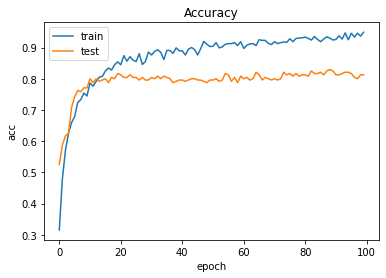

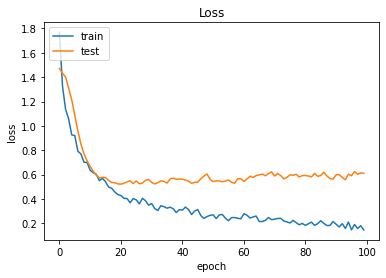

----- end training  cnn1d  -----
Accuracy: 0.812



In [26]:
config = parse_opt(config_name)
train(config)

## 预测数据

In [27]:
import os

In [28]:
def predict(config, audio_path: str, model) -> None:
    test_feature = get_data(config, audio_path, train=False)
    result = model.predict(test_feature)
    result_prob = model.predict_proba(test_feature)
    print('Recogntion: ', config.class_labels[int(result)])
    print('Probability: ', result_prob)
    radar(result_prob, config.class_labels)

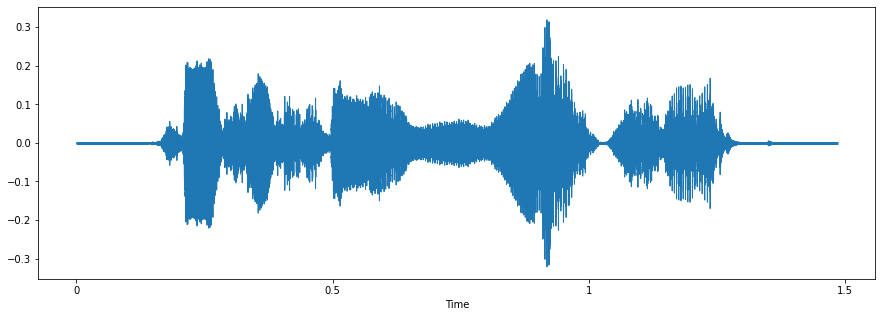

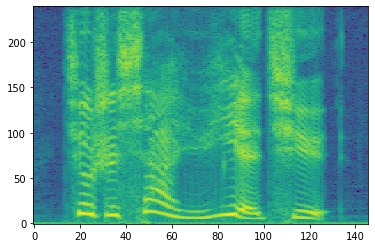

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 312, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 312, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 312, 32)           0         
                                                                 
 dropout (Dropout)           (None, 312, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 312, 32)           5152      
                                                                 
 batch_normalization_1 (Batc  (None, 312, 32)          128       
 hNormalization)                                        

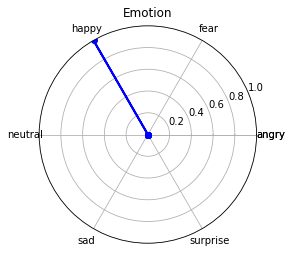

In [29]:
audio_path = 'D:/code/python/mySpeech/201.wav'
# play_audio(audio_path)
waveform(audio_path)
spectrogram(audio_path)
config = parse_opt(config_name)
model = model_load(config)
predict(config, audio_path, model)